In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# Hyperparameter
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#TODO this is the size of the training data set which you will get below
training_size= 160000 
test_portion=.1
corpus = []


In [ ]:
# Ingest a cleaned version of the data set from https://www.kaggle.com/kazanova/sentiment140

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        list_item.append(0) if row[0] == '0' else list_item.append(1)
        # TODO: 1st item in list_item is the text found in index [5]; 2nd item is the label: it should be 0 if the first item of the row is '0'. Otherwise, the label should be '1'

        num_sentences = num_sentences + 1
        corpus.append(list_item)


--2020-04-30 04:05:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   150MB/s    in 1.5s    

2020-04-30 04:05:26 (150 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index) 

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:]

In [ ]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138494
# 1

138775
1


In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford
# Laurence Moroney unzipped and hosted it on his site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-04-30 04:05:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   119MB/s    in 2.8s    

2020-04-30 04:05:41 (119 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
print(len(embeddings_matrix))
# Expected Output
# 138495

138776


In [ ]:
training_labels = np.asarray(training_labels)
test_labels = np.asarray(test_labels)

model = tf.keras.Sequential([
    #TODO 
    # Embedding layer
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # Dropout of 20%
    tf.keras.layers.Dropout(0.2),
    # Conv1D layer
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    # MaxPooling1D with size 4
    tf.keras.layers.MaxPooling1D(4),
    # LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Output Dense layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13877600  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 128)            98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2

<Figure size 432x288 with 0 Axes>

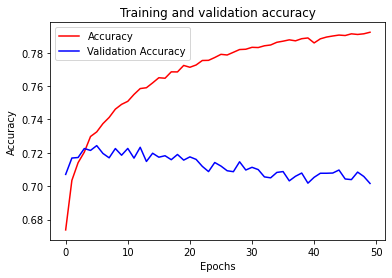

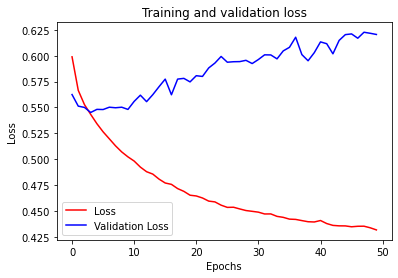

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

# Expected Output
# A chart where the validation loss does not increase sharply!
# The graph should look like something below

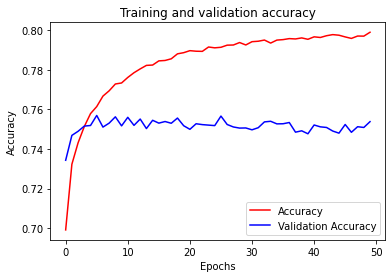

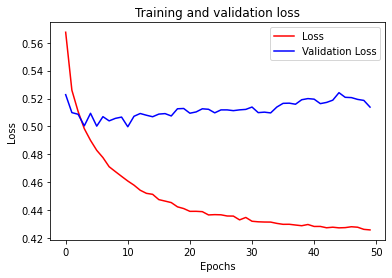